In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [4]:
BIG_TITLE="CNN EEG spectral features movement intention"

In [5]:
### TIME WINDOWS
w1=768
w2=0
W1=w1
W2=w2

In [6]:
### LIBRARIES

import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy
import datetime
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import tensorflow as tf
import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import time
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas
import os

# Remove some unwanted warnings
import logging
logging.getLogger('tensorflow').disabled = True 
from scipy.signal import butter, lfilter
import pywt
import pandas as pd
import numpy as np
import random
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy
import scipy
import scipy.signal
from scipy import fft
### LIBRARIES

import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy
import datetime
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import tensorflow as tf
import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import time
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy
import pandas
import os

import os
import sys

import pandas as pd
import pandas
import numpy as np

import pywt
import scipy.io as spio
from scipy.stats import entropy
from collections import Counter

from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

import timeit

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import tensorflow as tf
import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from numpy import hstack, vstack, dstack
import numpy as np


In [7]:
def load_signal(k):  #where k is the file name
    data = sio.loadmat(str(k))  
    ###deleting EOGs
    signal_raw= numpy.delete(data["signal"], obj= [63,62,61,60,59,58], axis=0)
    ###deleting 0s:
    signal_raw_trans= numpy.transpose(signal_raw)
    ind=[]
    for cx, c in enumerate(signal_raw_trans):
        if len(c) -  numpy.count_nonzero(c) <=5:
            continue
        else:
            ind.append(cx)
    g= numpy.delete(signal_raw_trans, obj= ind, axis=0)
    signal_raw_trans_clean=numpy.transpose(g)
    
    ###clean memory
    del data
    del signal_raw
    del signal_raw_trans
    del g

    return(signal_raw_trans_clean)

In [8]:
### cleaned code names
def cleaned_code_names(k):# k=file name
    data = sio.loadmat(str(k)) 
    events= data["header"]["event_codes"]
    EVENTS=[]
    for i in events:
        for e in i:
            for j in e:
                for h in j:
                    if len(str(h))>2:
                        EVENTS.append(h)
    EVENTS=numpy.array(EVENTS)
    
    del data
    del events
    
    return EVENTS

In [9]:
### cleaned event code
def event_Code(k): # k=file name
    data = sio.loadmat(str(k)) 
    
    labels= str(data["events"]["codes"]).split()
    
    l=[]
    for g in labels:
        for i in g:
            if i.isnumeric():
                l.append(i)
        else:
            l.append(",")
    #cleaning labels 
    l2=[]
    g=""
    for j in l:
        if j.isnumeric():
            g+=j
        elif len(g)<1:
            continue
        else:
            l2.append(int(g))
            g=""
    
    del data
    del labels
    del l
    del g
    
    return l2

### cleaned event position
def event_Position(k):# k=file name
    data = sio.loadmat(str(k)) 
    indices_signal_matrix= str(data["events"]["positions"]).split()
    #cleaning indices_signal_matrix 
    l3=[]
    for g in indices_signal_matrix:
        for i in g:
            if i.isnumeric():
                l3.append(i)
        else:
            l3.append(",")

    l4=[]
    g=""
    for j in l3:
        if j.isnumeric():
            g+=j
        elif len(g)<1:
            continue
        else:
            l4.append(int(g))
            g=""
    l4=l4[:-1]#array of i
    
    del data
    del indices_signal_matrix
    del l3
    del g
    
    return l4

In [10]:
#indexes of each events within signals
def indexes_event_signals(k):
    data = sio.loadmat(str(k)) 
    EVENTS = cleaned_code_names(k)
    event_codes= event_Code(k)
    dico_indexes={}

    for event in EVENTS:
        indexes_=[]
        for ig, g in enumerate(event_codes):
            if g == event:
                indexes_.append(ig)
        dico_indexes[event]= indexes_
    
    del data
    del EVENTS
    del event_codes
    del indexes_
    
    return dico_indexes

In [11]:
def start_indexes(k, event):# k= file name, starting_event= code of grasp onset, ending_event:code of grasp offset
    indexes=indexes_event_signals(k)
    event_positions= event_Position(k)
    event_indexes=[]
    
    for h in indexes[event]:
        event_indexes.append(event_positions[h])
    
    del indexes
    del event_positions
    
    return event_indexes

In [12]:
#signals of movement types (signal of split() function)


def EVENT_SIGNALS(k, EVENT, W1, W2): #starting_event= starting event of the movement, ending_event:ending event of the movement
    #window_size2=int(window_size/2)
    signal= load_signal(str(k)) 
    event_indexs= start_indexes(str(k), EVENT)

    movement_signals=[]
    #print(event_indexs)
    for i in event_indexs:#
        for channel in signal:
            i= int(i)
            #print(i+(window_size2))
            if i-W1>0:
                movement_signals.append(numpy.array(channel[i-W1:i+W2]))# window size would be are most litte event, event would be the ending event
            #print(len(channel[i-window_size2:i+(window_size2+1)]))
            else:
                continue
    del signal
    del event_indexs
    
    return movement_signals


In [13]:
def create_tensor(data,W1:int, W2,nb_channels:int):
    window_size= W1+W2
    positions_split=[]

    for j in range(0,len(data),nb_channels):
        positions_split.append(j)

    positions_split.append(len(data))
    #print(positions_split)

    all_events=[]
    for i in range(0,len(positions_split)-1):
        #print(i)
        one_event=[]
        for h in range(positions_split[i],positions_split[i+1]):
            #print(h)
            data_shaped=data[h]
            if (len(one_event)==0.0):
                one_event=data_shaped
            else:
                one_event=numpy.vstack((one_event, data_shaped))
        if (len(all_events)==0.0):
                all_events=one_event.reshape(1,nb_channels,window_size)
        else:
                all_events=numpy.vstack((all_events, one_event.reshape(1,nb_channels,window_size)))
        #print(all_events.shape)
    return(all_events)

In [14]:
import random
import numpy as np

def random_shuffle(final_TENSOR, labels):
    random_indexes_tens= random.sample(range(0, final_TENSOR.shape[0]), final_TENSOR.shape[0])
    event_tensors= [t for t in range(final_TENSOR.shape[0])]#indexes of tensor
    
    #print(random_indexes_tens)
    #print(event_tensors)

    SHUFFLED_TENSOR=[] 
    LABELS_SHUFFLED=[]
    
    for i in event_tensors:
        target_position=random_indexes_tens[i]
        SHUFFLED_TENSOR.append(final_TENSOR[target_position,:,:])
        LABELS_SHUFFLED.append(labels[target_position])

    SHUFFLED_TENSOR=numpy.array(SHUFFLED_TENSOR)
    #SHUFFLED_TENSOR= np.transpose(SHUFFLED_TENSOR, (1,2,0))
    return SHUFFLED_TENSOR, LABELS_SHUFFLED

In [15]:
# Remove some unwanted warnings
import logging
logging.getLogger('tensorflow').disabled = True 

def add_data(W1:int, W2:int,k:str,event_label:str,EVENT,nb_channels:int):
    #window_size=W1+W2
    partial_TENSOR=[]
    partial_LABEL=[]
    time00 = datetime.datetime.now()
    #for i in k:
    time1 = datetime.datetime.now()
    file='G'+k+'.mat'
    print('processing '+file)
    data=EVENT_SIGNALS(k=file, EVENT=EVENT, W1=W1, W2=W2 )
    data_transformed=create_tensor(data=data,W1=W1, W2=W2,nb_channels=nb_channels)
    label= event_label*data_transformed.shape[0]
    
    if (len(partial_TENSOR)==0.0):
        partial_TENSOR=data_transformed
        partial_LABEL=label
    else:
        partial_TENSOR=numpy.vstack((partial_TENSOR, data_transformed))
        partial_LABEL=partial_LABEL+label
    print('New shape Tensor ', partial_TENSOR.shape)
    print('New shape label ', len(partial_LABEL))
    time2 = datetime.datetime.now()
    elapsedTime = time2 - time1
    print('Minutes it took',elapsedTime)
        
    time01 = datetime.datetime.now()
    elapsedTime0 = time01 - time00
    print('Total time',elapsedTime0)

    return(partial_TENSOR, partial_LABEL) 

In [16]:
data = sio.loadmat(str("G01.mat"))
EEG_signals= load_signal("G01.mat")
header_channels_labels= data["header"]["channels_labels"]#living out EOGs
header_channels_labels_filtered=[]
for i in header_channels_labels:
    for j in i:
        for s in j:
            for ij in s:
                for ix in ij:
                    header_channels_labels_filtered.append(str(ix).strip())
header_channels_labels_filtered=header_channels_labels_filtered[:-6]

In [17]:
#band pass filter between 0.5 and 40 hz
from scipy.signal import butter, lfilter
import pywt
import pandas as pd
import numpy as np

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [18]:
ch=58
nb_ch=58
fs = 256.0
lowcut = 0.5
highcut = 60.0
a = 0.02
f0 = 256.0
T = 1.0 / 256.0
w = pywt.Wavelet('db4')

def get_Filter_FeatExtract(file,W1,W2, nb_ch):
    P1_reach= EVENT_SIGNALS(file, EVENT= 503587, W1=W1, W2=W2)
    P1_reach2=EVENT_SIGNALS(file, EVENT= 503588, W1=W1, W2=W2)
    P1_grasp= EVENT_SIGNALS(file, EVENT= 501794, W1=W1, W2=W2)
    P1_grasp2=EVENT_SIGNALS(file, EVENT= 501795, W1=W1, W2=W2)
    
    P1_reach= create_tensor(P1_reach,W1=W1, W2=W2,nb_channels=nb_ch)
    P1_reach2=create_tensor(P1_reach2,W1=W1, W2=W2,nb_channels=nb_ch)
    P1_grasp=create_tensor(P1_grasp,W1=W1, W2=W2,nb_channels=nb_ch)
    P1_grasp2=create_tensor(P1_grasp2,W1=W1, W2=W2,nb_channels=nb_ch)
         

    for event_i in range(0,P1_reach.shape[0]):  
      print(P1_reach.shape)
      print(P1_reach[event_i].shape)
      y_r = butter_bandpass_filter(P1_reach[event_i], lowcut, highcut, fs, order=6)
      #print(P1_reach[event_i].shape)#(58, 1280)
      print(y_r.shape)
      #array_r = Implement_Notch_Filter(T, 1, 60, 1, 2, 'butter', y_r)
      maxlev = pywt.dwt_max_level(len(y_r), w.dec_len)
      # maxlev = 2 # Override if desired
      #print("maximum level is " + str(maxlev)) #max level is 3
      threshold = 0.04 #
      data= y_r
      coeffs = pywt.wavedec(data, 'db4', level=maxlev)# 
      datarec = pywt.waverec(coeffs, 'db4')
      print("datarec",datarec.shape)
      try:
        partial_reachF=numpy.vstack((partial_reachF,datarec.reshape(1, datarec.shape[0], datarec.shape[1])))#.reshape(nb_ch,window_size)))
      except NameError:
        partial_reachF=datarec.reshape(1, datarec.shape[0], datarec.shape[1])#.reshape(nb_ch,window_size)
    print("Partial reachF", partial_reachF.shape)
    del y_r
    del P1_reach

    for event_i in range(0,P1_reach2.shape[0]): 
      y_r = butter_bandpass_filter(P1_reach2[event_i], lowcut, highcut, fs, order=6)
      #array_r = Implement_Notch_Filter(T, 1, 60, 1, 2, 'butter', y_r)
      maxlev = pywt.dwt_max_level(len(y_r), w.dec_len)
      # maxlev = 2 # Override if desired
      threshold = 0.04 #
      data= y_r
      coeffs = pywt.wavedec(data, 'db4', level=maxlev)# 
      datarec = pywt.waverec(coeffs, 'db4')
      try:
        partial_reachFF=numpy.vstack((partial_reachFF,datarec.reshape(1, datarec.shape[0], datarec.shape[1])))#.reshape(nb_ch,window_size)))
      except NameError:
        partial_reachFF=datarec.reshape(1, datarec.shape[0], datarec.shape[1])#.reshape(nb_ch,window_size)

    del y_r
    del P1_reach2

    for event_i in range(0,P1_grasp.shape[0]):  
      y_r = butter_bandpass_filter(P1_grasp[event_i], lowcut, highcut, fs, order=6)
      maxlev = pywt.dwt_max_level(len(y_r), w.dec_len)
      # maxlev = 2 # Override if desired
      threshold = 0.04 #
      data= y_r
      coeffs = pywt.wavedec(data, 'db4', level=maxlev)# 
      datarec = pywt.waverec(coeffs, 'db4')
      try:
        partial_graspF=numpy.vstack((partial_graspF,datarec.reshape(1, datarec.shape[0], datarec.shape[1])))#.reshape(nb_ch,window_size)))
      except NameError:
        partial_graspF=datarec.reshape(1, datarec.shape[0], datarec.shape[1])#.reshape(nb_ch,window_size)

    del y_r
    del P1_grasp

    for event_i in range(0,P1_grasp2.shape[0]): 
      y_r = butter_bandpass_filter(P1_grasp2[event_i], lowcut, highcut, fs, order=6)
      #array_r = Implement_Notch_Filter(T, 1, 60, 1, 2, 'butter', y_r)
      maxlev = pywt.dwt_max_level(len(y_r), w.dec_len)
      # maxlev = 2 # Override if desired
      #print("maximum level is " + str(maxlev)) #max level is 3
      threshold = 0.04 #
      data= y_r
      coeffs = pywt.wavedec(data, 'db4', level=maxlev)# 
      datarec = pywt.waverec(coeffs, 'db4')
      try:
        partial_graspFF=numpy.vstack((partial_graspFF,datarec.reshape(1, datarec.shape[0], datarec.shape[1])))#.reshape(nb_ch,window_size)))
      except NameError:
        partial_graspFF=datarec.reshape(1, datarec.shape[0], datarec.shape[1])#.reshape(nb_ch,window_size)

    del y_r
    del P1_grasp2
    
    #print(partial_reachF.shape)#(4582, 1280)
    #print(partial_reachFF.shape)#(4582, 1280)
    partial_reach= numpy.vstack([partial_reachF, partial_reachFF])
    labels_reach= ["reach"]*partial_reach.shape[0]
    partial_grasp=numpy.vstack([partial_graspF, partial_graspFF])
    labels_grasp=["grasp"]*partial_grasp.shape[0]
    return partial_reach, labels_reach, partial_grasp, labels_grasp


In [19]:

from keras.callbacks import ModelCheckpoint, EarlyStopping

def run_model():
  nb_channels=58
  window_size=W1+W2
  model = Sequential()
  seed_value=333        
    
    #####
    #####
  model.add(Conv2D(filters = 64, kernel_size = (7,7), padding = "same", activation = "elu", input_shape = (nb_channels,window_size,1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (3,3)))
  model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = "same", activation = "elu"))
#model.add(Activation('elu'))# Is this needed? Try without it
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (3,3)))
  model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "elu"))
#model.add(Activation('elu'))#Is this needed? Try without it
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (3,3)))
  model.add(Flatten())
  model.add(Dropout(0.2)) #seed=seed_value)
  model.add(Dense(32, activation = "elu"))
  #model.add(Activation('elu'))#Is this needed? Try without it
  model.add(BatchNormalization())
#model.add(Dropout(0.2))
  model.add(Dense(1, activation = "sigmoid"))#try softax


  adam = Adam(learning_rate = 0.0001)

  model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ['accuracy','mse'])
  # simple early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)# add "patience=200" if early stopping is done too soon
  return model, es, adam
model, es, adam= run_model()

In [20]:
with open("model summary "+str(BIG_TITLE)+'.pdf', 'w') as f:
  model.summary(print_fn=lambda x: f.write(x + '\n'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 768, 64)       3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 58, 768, 64)       256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 256, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 256, 64)       102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 256, 64)       256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 85, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 85, 64)         3

In [22]:
import matplotlib.pyplot as pyplot
import csv

def plot_training_history(history, TITLE):
    acc = history.history['accuracy']
    loss = history.history['loss']
    mse = history.history['mse']
    epochs = range(len(acc))
 
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 1, 1)
    plt.plot(epochs, acc, 'g', label='Training accuracy',linewidth=2) #'g'
    plt.plot(epochs, loss, 'r', label='Training loss',linewidth=2)
    plt.plot(epochs, mse, 'b--', label='MSE',linewidth=2)
    #plt.plot(epochs, ACC, 'g', label='Test acc',linewidth=2)
    plt.title(TITLE, fontsize=10)
    plt.xlabel('Number of epochs', fontsize=8)
    plt.ylabel('Performance indicator', fontsize=8)
    plt.legend()
    
    plt.savefig(str(TITLE)+'.png', bbox_inches='tight')
    plt.savefig(str(TITLE)+'.pdf', bbox_inches='tight')
    #plt.show()

Streaming output truncated to the last 5000 lines.
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(80, 58, 768

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(78, 58, 768

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(69, 58, 768

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768)
(58, 768)
(58, 768)
datarec (58, 768)
(76, 58, 768

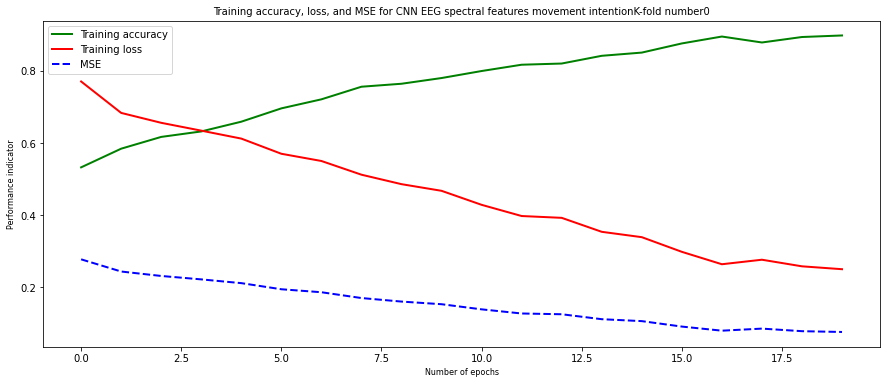

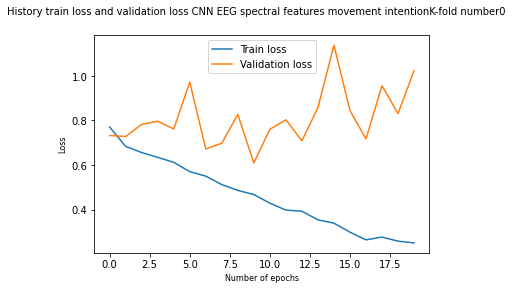

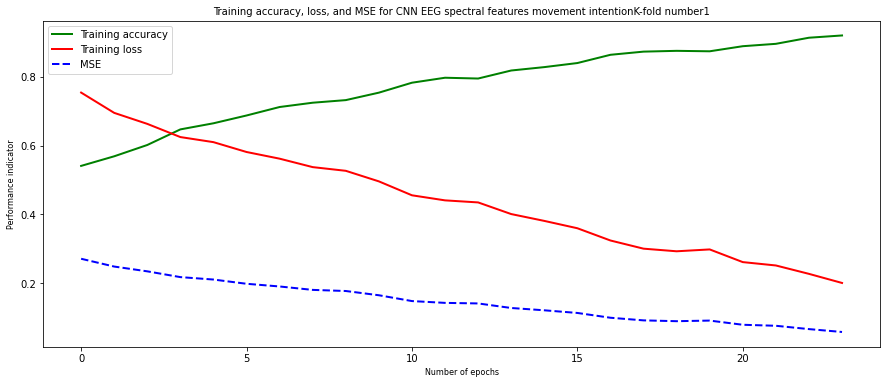

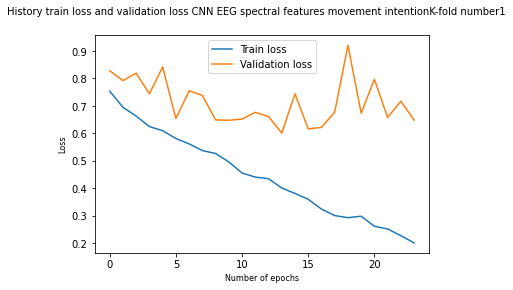

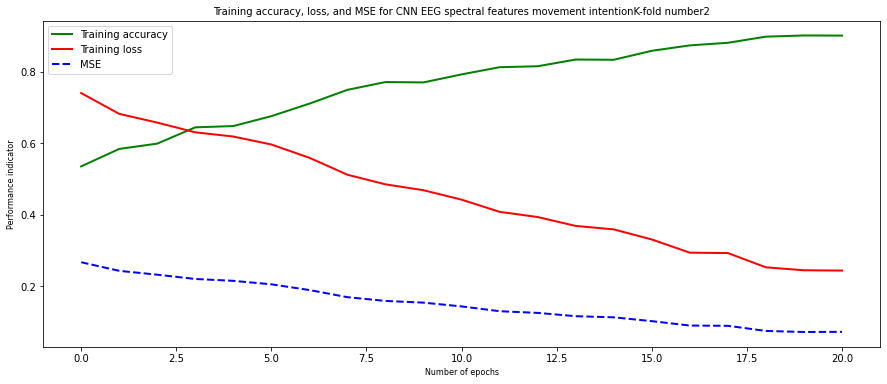

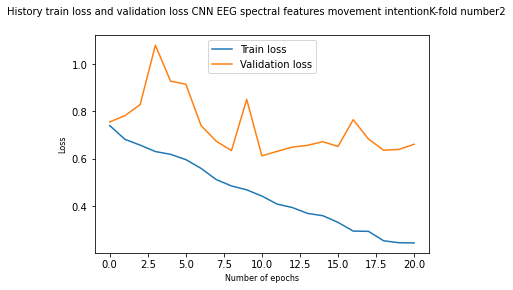

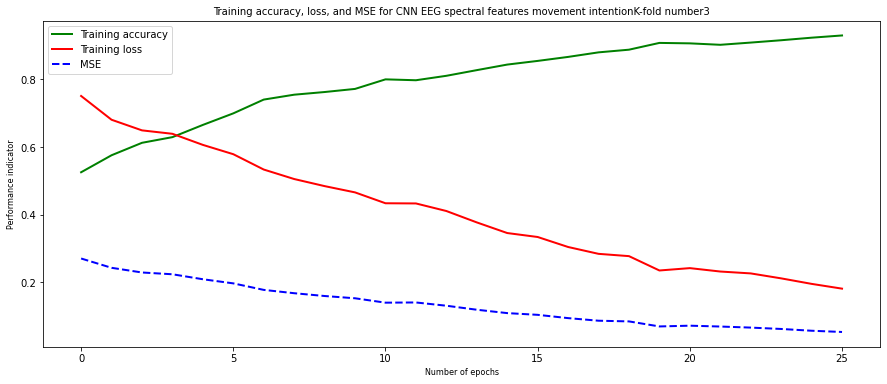

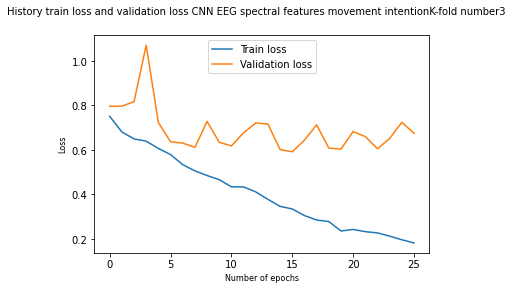

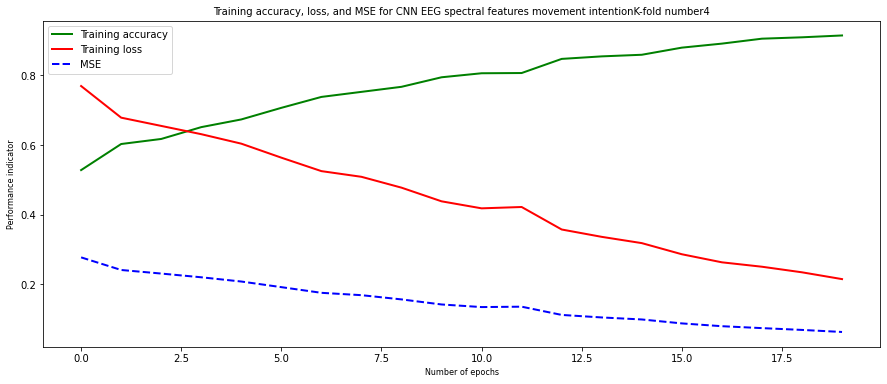

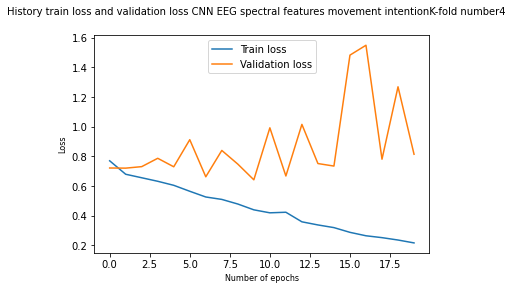

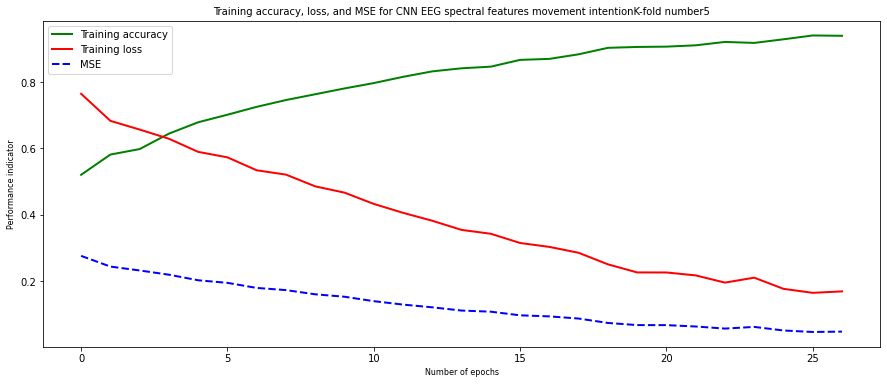

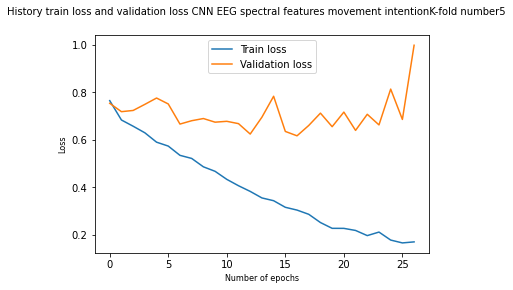

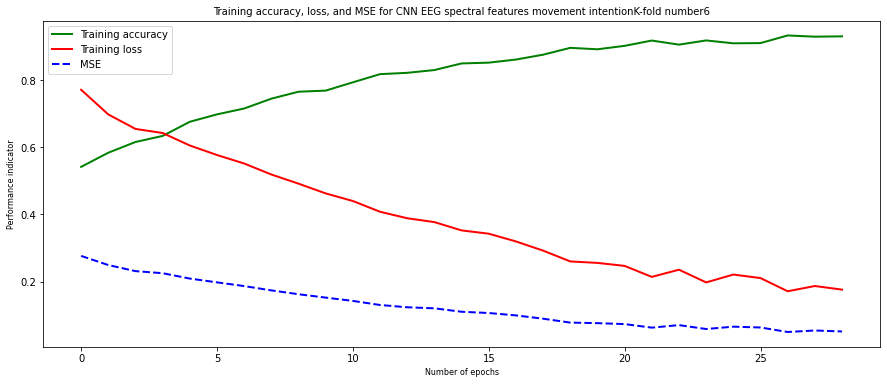

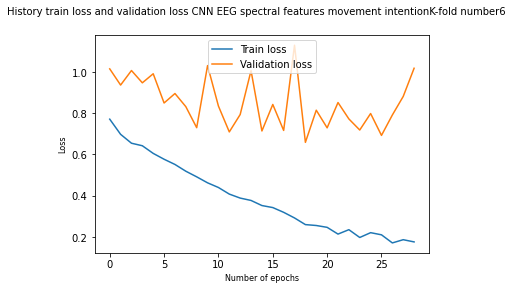

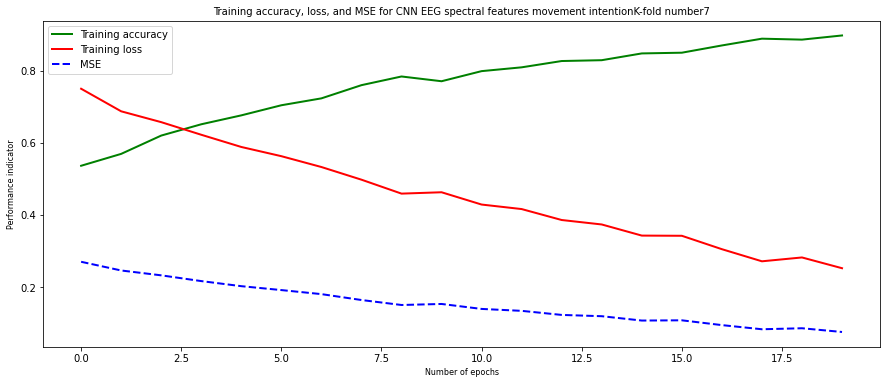

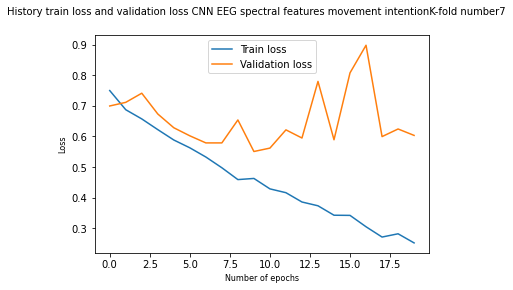

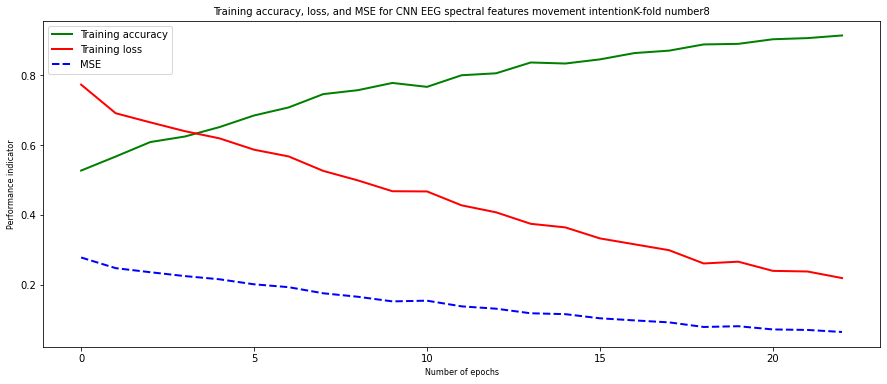

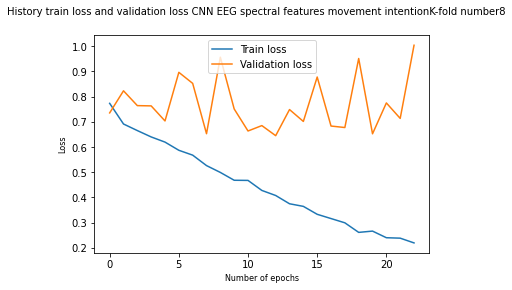

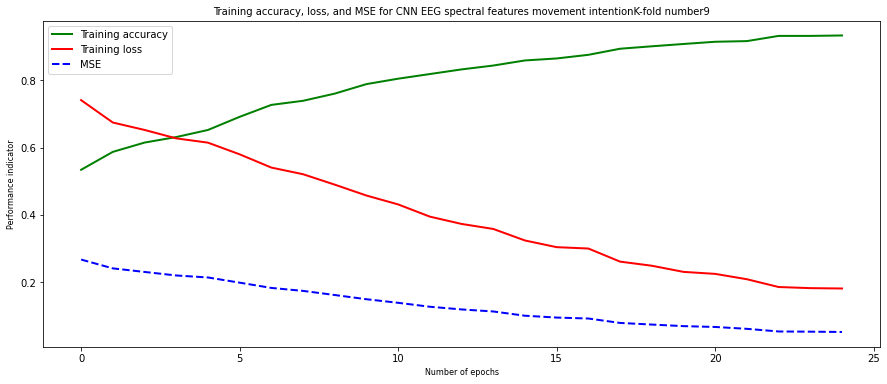

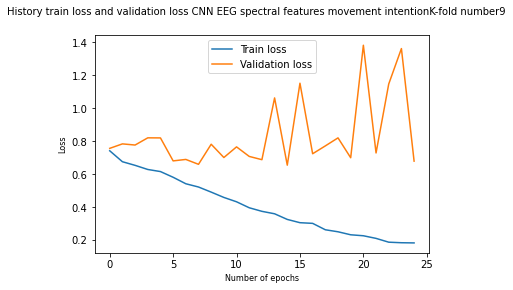

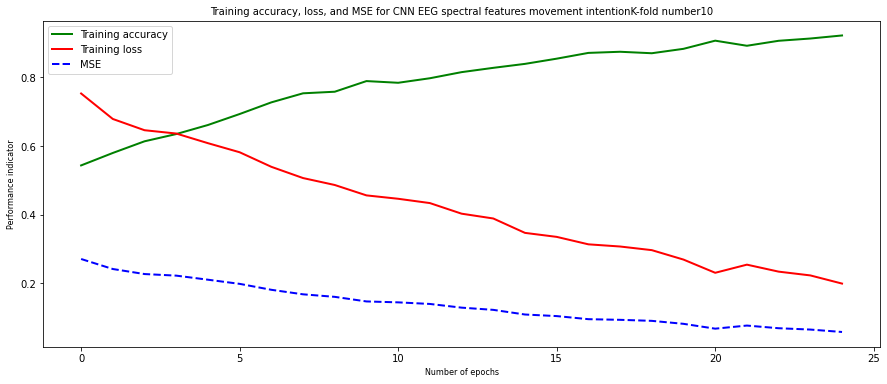

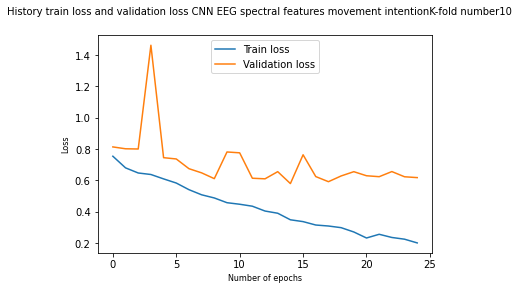

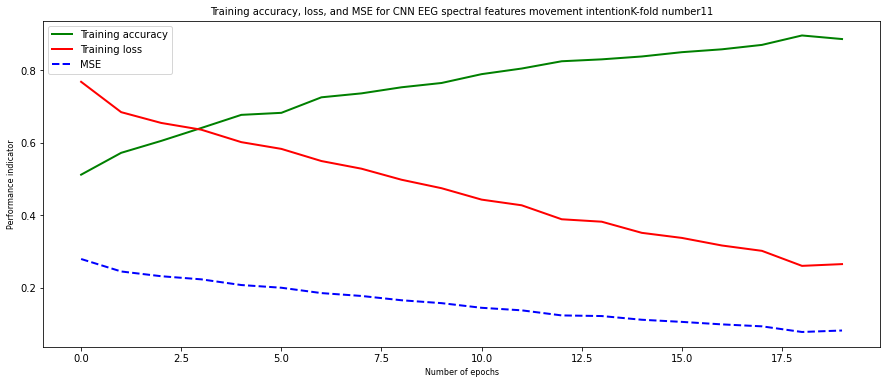

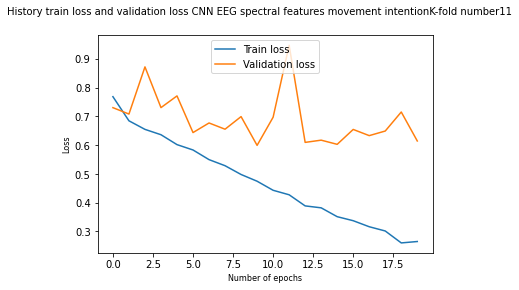

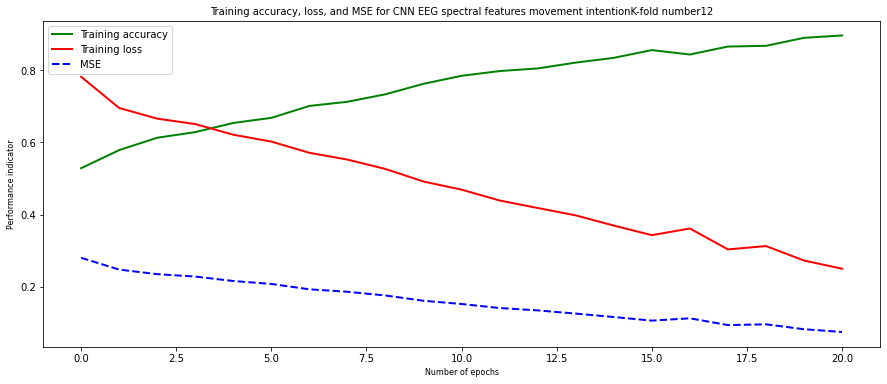

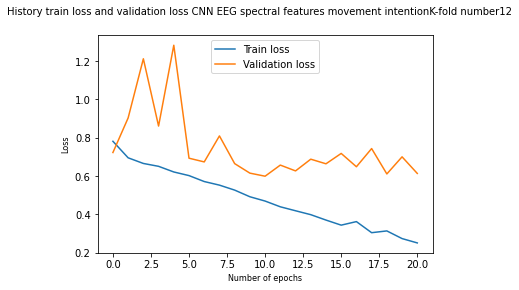

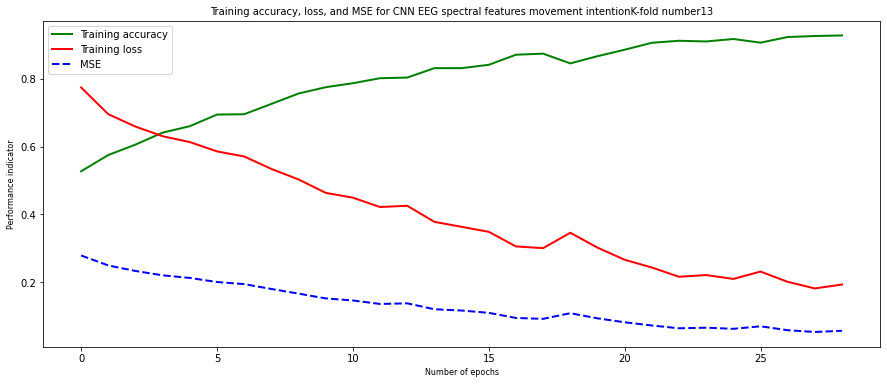

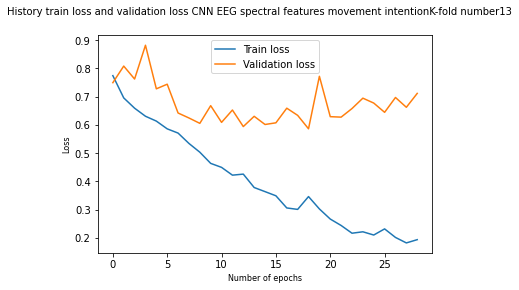

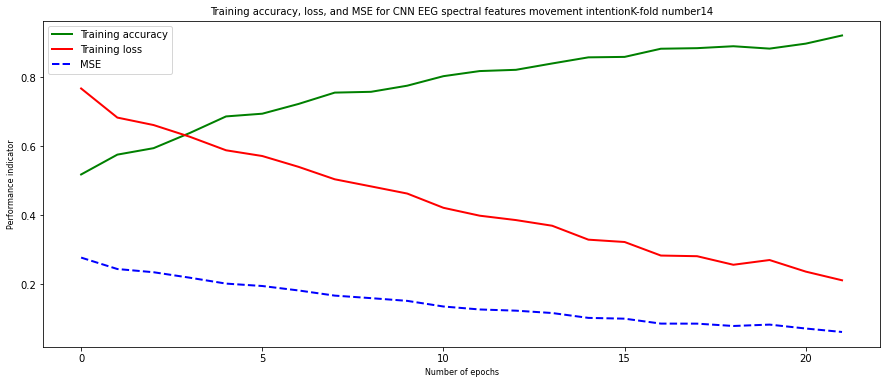

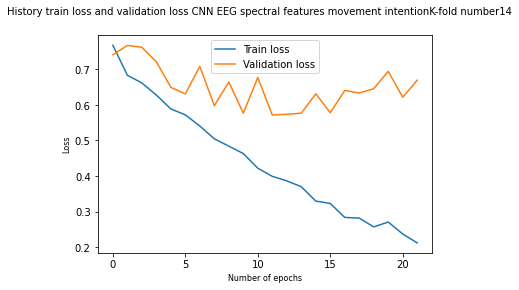

In [23]:

nb_channels=58
nb_ch=nb_channels
window_size=W1+W2

training_accuracies=[]
test_accuracies=[]

histories={}
training_time=[]

files= ['G01.mat','G02.mat','G03.mat','G04.mat','G05.mat','G06.mat','G07.mat','G08.mat','G09.mat','G10.mat','G11.mat','G12.mat','G13.mat','G14.mat','G15.mat']

for g in range(len(files)):
  train_files= files[:g]+ files[g+1:]
  test_file=[files[g]]
  model, es, adam=run_model()

  for file in train_files:
    partial_reach, labels_reach, partial_grasp, labels_grasp=get_Filter_FeatExtract(file,W1,W2, nb_ch)
    beside= vstack((partial_reach,partial_grasp))
    beside2=labels_reach+labels_grasp
    try:
      FINAL_TENSOR= vstack((FINAL_TENSOR, beside))
      FINAL_LABELS= FINAL_LABELS+beside2
    except NameError:
      FINAL_TENSOR=beside
      FINAL_LABELS=beside2

  X_train, X_val, y_train, y_val = train_test_split(FINAL_TENSOR, FINAL_LABELS, test_size =0.3, random_state=0)

  X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
  X_val=X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2],1)

  print("x train shape", X_train.shape)
  print("x val shape", X_val.shape)
  print("y train length", len(y_train))
  print("y train length", len(y_val))

  del FINAL_TENSOR
  del FINAL_LABELS
  del beside
  del beside2

  onehot = LabelBinarizer()
  y_train = onehot.fit_transform(y_train)
  y_val = onehot.transform(y_val)
####
  
  start = time.time()
  TITLE= "Training accuracy, loss, and MSE for "+BIG_TITLE+ "K-fold number"+ str(g)
  histories[TITLE]= model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=10, callbacks=[es])#works with epochs = 10
  stop = time.time()  

  training_time.append(stop - start)

  training_accuracies.append(histories[TITLE].history['accuracy'])
  
# ### END ##
  
  plot_training_history(histories[TITLE], TITLE)

  

  fig = plt.figure()
  pyplot.plot(histories[TITLE].history['loss'], label='Train loss')
  pyplot.plot(histories[TITLE].history['val_loss'], label='Validation loss')

  TITLE= "History train loss and validation loss "+BIG_TITLE+ "K-fold number"+ str(g)
  fig.suptitle(TITLE, fontsize=10)
  plt.xlabel('Number of epochs', fontsize=8)
  plt.ylabel('Loss', fontsize=8)

  pyplot.legend(loc='upper center')

  plt.savefig(str(TITLE)+'.png', bbox_inches='tight')
  plt.savefig(str(TITLE)+'.pdf', bbox_inches='tight')

  del X_train
  del X_val
  del y_train
  del y_val

#####################################################################################
  for file in test_file:
    partial_reach, labels_reach, partial_grasp, labels_grasp= get_Filter_FeatExtract(file,W1,W2, nb_ch)
    besidE= vstack((partial_reach,partial_grasp))
    besidE2=labels_reach+labels_grasp
    try:
      TEST_TENSOR= vstack((TEST_TENSOR, besidE))
      TEST_LABELS= TEST_LABELS+besidE2
    except NameError:
      TEST_TENSOR=besidE
      TEST_LABELS=besidE2

  TEST_TENSOR, labels_test=random_shuffle(TEST_TENSOR, TEST_LABELS)

  y_test = onehot.transform(TEST_LABELS)#RE PUT onehot.transform(labels_test)
  print("y test length:", len(y_test))
  TEST_TENSOR=TEST_TENSOR.reshape(TEST_TENSOR.shape[0],TEST_TENSOR.shape[1],TEST_TENSOR.shape[2],1)
  print("TEST_TENSOR shape:", TEST_TENSOR.shape)
  test_loss, test_acc, test_mse = model.evaluate(TEST_TENSOR, y_test)

  test_accuracies.append(test_acc)

  Test_acc= ["Test loss:", test_loss, "Test accuracy:", test_acc, "Test MSE:", test_mse]


##storing for ROC curve
  y_pred = model.predict(TEST_TENSOR)
  y_pred_keras=y_pred.ravel()
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
  ROC= ["fpr_keras:", fpr_keras, "tpr_keras :", tpr_keras, "thresholds_keras:", thresholds_keras]
##storing for AUC curve
  auc_keras = auc(fpr_keras, tpr_keras)
  AUC= ["auc_keras:", auc_keras]


# Creating the Confusion Matrix
  y_pred_n=[]
  for i in y_pred:
    if i >= 0.5:
      y_pred_n.append(1)
    else:
      y_pred_n.append(0)
  y_pred= y_pred_n
#del y_pred_n
  cm = confusion_matrix(y_test, y_pred)
  print(cm)

  total1=sum(sum(cm))
#####from confusion matrix calculate accuracy
  accuracy1=(cm[0,0]+cm[1,1])/float(total1)
  acc="Accuracy : %f" %(accuracy1*100)
  print("Accuracy : %f" %(accuracy1*100))

  sensitivity1 = float(cm[0,0])/(cm[0,0]+cm[0,1])
  sens="Sensitivity :%f" %(sensitivity1*100)
  print("Sensitivity :%f" %(sensitivity1*100))

  specificity1 = float(cm[1,1])/(cm[1,0]+cm[1,1])
  spe="Specificity :%f"%(specificity1*100)
  print("Specificity :%f"%(specificity1*100))

  precision1 = float(cm[0,0])/(cm[0,0]+cm[1,1])
  pre="Precision :%f" %(precision1*100)
  print("Precision :%f" %(precision1*100))

  F1score= 2*((precision1*sensitivity1)/(precision1+sensitivity1))
#accuracies["Confusion Matrix CNN 20 epochs"]= ["Confusion matrix:", cm, "Accuracy:", accuracy1, "Sensitivity:", sensitivity1, "Specificity:", Specificity, "Precison:", precision1, "F1score:", F1score]

  
  TITLE= "Test results & training time "+BIG_TITLE+ "K-fold number"+ str(g)


  with open(str(TITLE)+".csv", 'w', newline='', ) as file:
      writer = csv.writer(file)
      writer.writerow(["Test acc:", Test_acc])
      writer.writerow(["ROC:", ROC])
      writer.writerow(["AUC:", AUC])
      writer.writerow(["CM:",cm])
      writer.writerow(["accuracy:",acc])
      writer.writerow(["sensitivity/recall:", sens])
      writer.writerow(["specificity:", spe])
      writer.writerow(["precision",pre])
      writer.writerow(["Training time:", training_time])

  del TEST_TENSOR
  del TEST_LABELS
  del besidE
  del besidE2
  del y_test
  del y_pred

In [24]:
import math

def variance(data, ddof=0):
  n = len(data)
  mean = sum(data) / n
  return sum((x - mean) ** 2 for x in data) / (n - ddof)

def stdev(data):
  var = variance(data)
  std_dev = math.sqrt(var)
  return std_dev

def Average(lst):
    return sum(lst) / len(lst)

SE_test= stdev(test_accuracies)
Mean_accuracy= Average(test_accuracies)

with open(str(BIG_TITLE+"SE")+".csv", 'w', newline='', ) as file:
      writer = csv.writer(file)
      writer.writerow(["SE_test", SE_test])
      writer.writerow(["Mean_accuracy", Mean_accuracy])

In [25]:
print(SE_test*100)

1.9347796234869648


In [26]:
print(Mean_accuracy*100)

48.84526868661245
